Imports.

In [1]:
from enum import Enum
from typing import NamedTuple
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, UpSampling2D, ZeroPadding2D, \
                         Cropping2D, Reshape
import keras
from numba import njit

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Definições, inicializações e funções utilitárias.

In [2]:
#The tolerance for floating pointer comparison
epsilon = 0.000001

#The complexity of the variogram models
numberOfNestedStructures = 4
numberOfParametersPerNestedStructure = 4 #ATTENTION: if you change this value, you must change the makeVariogramModelSurface() function accordingly
totalNumberOfParameters = numberOfNestedStructures * numberOfParametersPerNestedStructure

#The target sill for the variogram models
sill = 0.64

#The range for the longest structure allowed in the variogram models
maxAxis = 50.0

class StructureType(Enum):
    Spheric     = 1
    Exponential = 2
    Gaussian    = 3
    
class EllipsoidParameters(NamedTuple):
    Azimuth      : float
    SemiMajorAxis: float
    SemiMinorAxis: float

class GridParameters(NamedTuple):
    X0: float
    Y0: float
    DX: float
    DY: float
    NI: int
    NJ: int

def getExtent2D( gridParameters : GridParameters ) -> np.array :
    gridCornerX = gridParameters.X0 - gridParameters.DX/2;
    gridCornerY = gridParameters.Y0 - gridParameters.DY/2;
    return [
           gridCornerX,
           gridCornerX + gridParameters.DX*gridParameters.NI,
           gridCornerY,
           gridCornerY + gridParameters.DY*gridParameters.NJ
           ]

def getGridParameters() -> GridParameters :
    return GridParameters( X0=-50., Y0=-50., 
                           DX=1,    DY=1, 
                           NI=100,  NJ=100 )    

Função gera superfície variográfica

In [3]:
@njit
def makeVariographicSurface( structureType       : StructureType, 
                             ellipsoidParameters : EllipsoidParameters, 
                             contribution        : float,
                             gridParameters      : GridParameters ) -> np.array :
   #NOTA VARIAVEIS COM [0] APARENTEMENTE DE FORMA DESNECESSARIA
   #sem isso dá erro de tipo não reconhecido (array) ao tentar usar com o JIT do Numba.
   #
   #Cria o numpy.array seguindo os parâmetros do grid.
   grid = np.zeros(( gridParameters.NI, gridParameters.NJ ));
   #Check for null structure
   if( contribution[0] < epsilon or 
       ellipsoidParameters.SemiMajorAxis[0] < epsilon or 
       ellipsoidParameters.SemiMinorAxis[0] < epsilon ) :
       return grid;
   #Obtem parâmetros geométricos
   a = ellipsoidParameters.SemiMajorAxis;
   b = ellipsoidParameters.SemiMinorAxis;
   c = contribution;                                       #contribution to semivariance
   theta = ellipsoidParameters.Azimuth/180.0 * math.pi; #azimuth
   xc = gridParameters.X0 - gridParameters.DX/2 + gridParameters.DX*gridParameters.NI/2; #center of the grid
   yc = gridParameters.Y0 - gridParameters.DY/2 + gridParameters.DY*gridParameters.NJ/2; #center of the grid
   #Calcula o variograma em cada célula do grid   
   for j in range( gridParameters.NJ ) :
      for i in range( gridParameters.NI ) :
         xCell = gridParameters.X0 + gridParameters.DX * i;
         yCell = gridParameters.Y0 + gridParameters.DY * j;
         x = (xCell - xc) * math.cos(theta[0]) - (yCell - yc) * math.sin(theta[0]);
         y = (xCell - xc) * math.sin(theta[0]) + (yCell - yc) * math.cos(theta[0]);
         modulusSquared = (x/a)*(x/a) + (y/b)*(y/b);
         h = math.sqrt( modulusSquared[0] );
         if( h >= 0. and h <= 1. ) :
            semivariance = c * (3*h/2.-math.pow(h, 3)/2.);
         else :
            semivariance = c;
         grid[i,j] = semivariance[0];
   #retorna o grid
   return grid;

Função para gerar a superfície de um modelo variográfico de 4 estruturas

In [4]:
# The parameters must be a linear 16-element array of floats in the following order:
# azimuth, semi-major axis, semi-minor axis, contribution, azimuth, ...
# for four structures.  Models with less than for structures can be specified with all-zero parameters
def makeVariogramModelSurface( parameters : np.array ) -> np.array :
    gridParameters = getGridParameters()
    variogramModelSurface = np.zeros(( gridParameters.NI, gridParameters.NJ ));
    for i in range( numberOfNestedStructures ) :
        variogramModelSurface += \
            makeVariographicSurface( structureType = StructureType.Spheric, 
                                     ellipsoidParameters = EllipsoidParameters( Azimuth      =parameters[i*numberOfParametersPerNestedStructure+0], 
                                                                                SemiMajorAxis=parameters[i*numberOfParametersPerNestedStructure+1], 
                                                                                SemiMinorAxis=parameters[i*numberOfParametersPerNestedStructure+2] ), 
                                     contribution=parameters[i*numberOfParametersPerNestedStructure+3],
                                     gridParameters = gridParameters )
    return variogramModelSurface;


Gerar estruturas variográficas simples e seus quatro parâmetros.

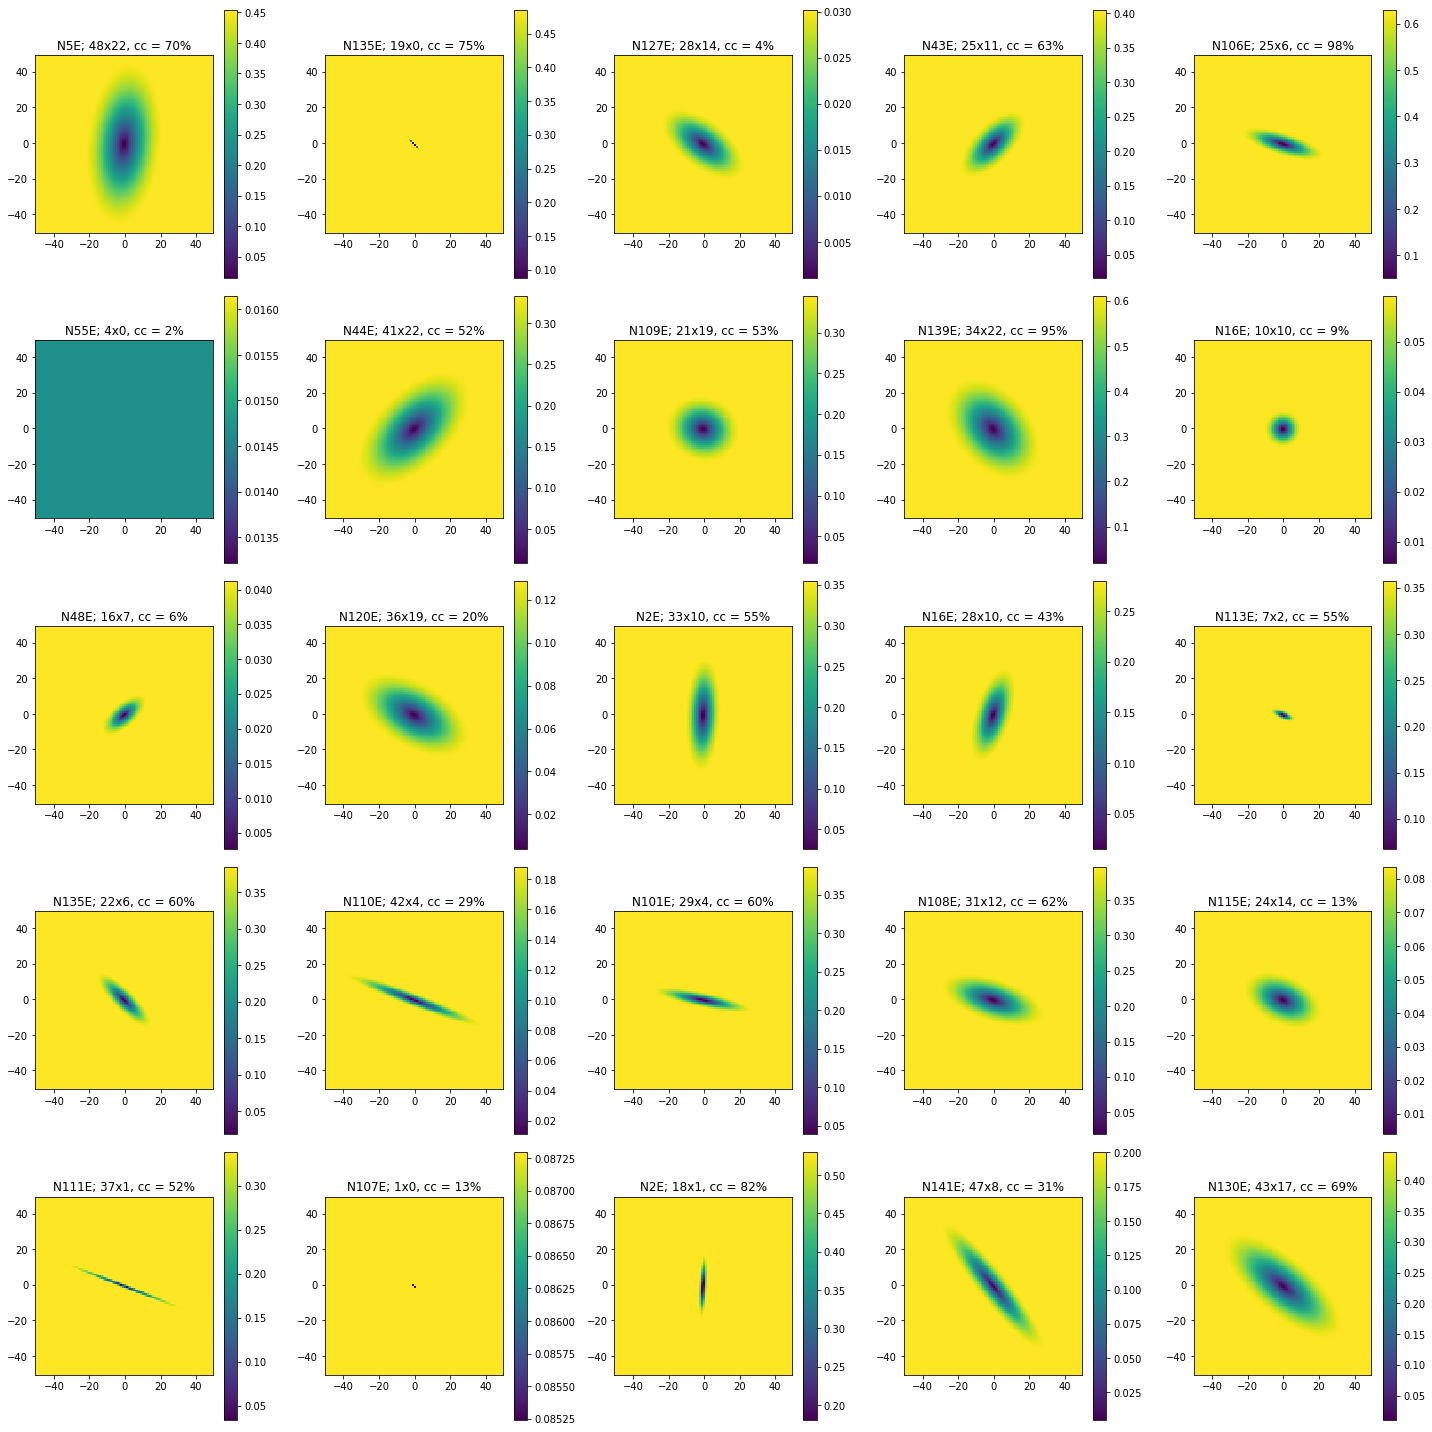

In [18]:
#The number of random variogram structures to generate
nStru = 5500

#Allocate a volume for the stack of all variogram structures nStru * 100 * 100
allStructures = np.zeros(( nStru, getGridParameters().NI, getGridParameters().NJ))

#Allocate the stack of variographic parameters per structure nStru * 4 * 1
allParameters = np.zeros(( nStru, numberOfParametersPerNestedStructure ))

#Generate the variogram structures for training
for iStructure in range(nStru):
    
    #Radomize the azimuth (N000E through N180E)
    az = np.random.rand(1, 1)
    
    #Randomize the semi-major axis
    a = np.random.rand(1, 1)

    #Randomize the semi-minor axis such that they are necessarily smaller than the semi-major axis
    b = a * np.random.rand(1, 1)
    
    #Randomize the contribution as a 0.0-1.0 fraction of the expected variogram model sill
    cc = np.random.rand(1, 1) 
    
    #Linearize the array of variographic parameters
    linearArrayOfParametersUnitized =  np.column_stack( (az, a, b, cc) ).\
                                           reshape(numberOfParametersPerNestedStructure,1)
    linearArrayOfParametersFullScale = np.column_stack( (az*180, a*maxAxis, b*maxAxis, cc*sill) ).\
                                           reshape(numberOfParametersPerNestedStructure,1)
    
    #Make variogram structure
    variogramStructure = \
        makeVariographicSurface( structureType = StructureType.Spheric, 
                                 ellipsoidParameters = EllipsoidParameters( Azimuth      =linearArrayOfParametersFullScale[0], 
                                                                            SemiMajorAxis=linearArrayOfParametersFullScale[1], 
                                                                            SemiMinorAxis=linearArrayOfParametersFullScale[2]), 
                                 contribution=linearArrayOfParametersFullScale[3],
                                 gridParameters = getGridParameters() )
   
    #Stack the variogram structure
    allStructures[iStructure,:,:] = variogramStructure
    
    #Stack the linearized variographic parameters
    allParameters[iStructure,:] = linearArrayOfParametersUnitized.reshape((numberOfParametersPerNestedStructure,))


#Prepare a plot area measuring 5 by 5 figures, each measuring 20x20
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

#Plot the first 25 variogram surfaces to check data
iStru = int(0)
for ax in axs.flat:

    #plot the variogram surface
    mappable = ax.imshow( allStructures[iStru,:,:], 
                    interpolation='none',
                    extent=getExtent2D( getGridParameters() ))
    fig.colorbar(mappable, ax=ax)
    ax.set_title( "N" + str(int(allParameters[iStru,0]*180)) + "E; " 
                      + str(int(allParameters[iStru,1]*maxAxis)) + "x"
                      + str(int(allParameters[iStru,2]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iStru,3])) + "%" )
    
    #Increment the synthetic structure index/count
    iStru = iStru + 1
    
#Lay out the plots
plt.tight_layout()
plt.show()



Constrói uma rede para treinar a associação ( azimute, semieixo maior, semieixo menor, contribuição) --> estrutura imbricada.

In [19]:

#Cria a parte codificadora
input_layer = Input(shape=(getGridParameters().NI, getGridParameters().NJ, 1))
encoder = ZeroPadding2D(padding=((14,14),(14,14))) ( input_layer )
encoder = Conv2D(16, kernel_size=3, activation='relu', padding='same') ( encoder ) #camada convolutiva de 16 kernels (corresponde a 16 neurônios)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same') ( encoder )
encoder = Conv2D(32, kernel_size=3, activation='relu', padding='same') ( encoder ) #camada convolutiva de 8 kernels (corresponde a 8 neurônios)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same') ( encoder )
encoder = Conv2D(64, kernel_size=3, activation='relu', padding='same') ( encoder ) #camada convolutiva de 8 kernels (corresponde a 8 neurônios)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same') ( encoder )
encoder = Conv2D(128, kernel_size=3, activation='relu', padding='same') ( encoder ) #camada convolutiva de 8 kernels (corresponde a 8 neurônios)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same') ( encoder )
encoder = Conv2D(256, kernel_size=3, activation='relu', padding='same') ( encoder ) #camada convolutiva de 8 kernels (corresponde a 8 neurônios)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same') ( encoder )
encoder = Conv2D(512, kernel_size=3, activation='relu', padding='same') ( encoder ) #camada convolutiva de 8 kernels (corresponde a 8 neurônios)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same') ( encoder )
encoder = Conv2D(1024, kernel_size=3, activation='relu', padding='same') ( encoder ) #camada convolutiva de 8 kernels (corresponde a 8 neurônios)
encoder = MaxPooling2D(pool_size=(2, 2)) ( encoder )

#Cria a parte deconvolutiva da parte decodificadora
decoder = Conv2D(1024, kernel_size=3, activation='relu', padding='same') ( encoder )
decoder = UpSampling2D((2, 2), interpolation='nearest') ( decoder )
decoder = Conv2D(512, kernel_size=3, activation='relu', padding='same') ( decoder )
decoder = UpSampling2D((2, 2), interpolation='nearest') ( decoder )
decoder = Conv2D(256, kernel_size=3, activation='relu', padding='same') ( decoder )
decoder = UpSampling2D((2, 2), interpolation='nearest') ( decoder )
decoder = Conv2D(128, kernel_size=3, activation='relu', padding='same') ( decoder )
decoder = UpSampling2D((2, 2), interpolation='nearest') ( decoder )
decoder = Conv2D(64, kernel_size=3, activation='relu', padding='same') ( decoder )
decoder = UpSampling2D((2, 2), interpolation='nearest') ( decoder )
decoder = Conv2D(32, kernel_size=3, activation='relu', padding='same') ( decoder )
decoder = UpSampling2D((2, 2), interpolation='nearest') ( decoder )
decoder = Conv2D(16, kernel_size=3, activation='relu', padding='same') ( decoder )
decoder = UpSampling2D((2, 2), interpolation='nearest') ( decoder )
decoder = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same') ( decoder ) 
decoder = Cropping2D(cropping=((14,14),(14,14))) ( decoder )

#Monta a arquitetura decoder completa
decoder_instance = Model(input_layer, decoder)

#Mostra o resumo da arquitetura
decoder_instance.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)        18496     
__________

In [20]:
#Normalizar os dados de entrada
#normalizer   = StandardScaler()
#X_norm = normalizer.fit_transform(X)
#ver se o normalizer traz para 0.0-1.0 mesmo
#normalizar as superfícies teóricas e o experimental na mesma escala (max de todos os mapas + experimental)
#colocar camadas de max/min pooling depois de cada camada convolutiva
#ver rede LeNet dado em um dos notebooks da aula.

#Dividir o conjunto total de superfícies variográficas e seus parâmetros em dois conjuntos:
#  1) O conjunto de treinamento, para o processamento do backpropagation.
#  2) O conjunto de teste, para aferição de métricas de acurácia da predição
trainParameters, testParameters, trainStructures, testStructures = \
      train_test_split(allParameters, allStructures, test_size=0.25, random_state=11111)
    
#Talvez tenha que rescalar os variogramas para 0.0-1.0

#Compatibiliza os dados de entrada para uso no Keras, que espera tensores (matrizes de ordem maior que 2)
#de ordem 4: # de imagens, dimensão I de cada imagem, dimensão J de cada imagem, # de canais em cada imagem
trainStructures = trainStructures.reshape(trainStructures.shape + (1,)) #(1,) significa uma tupla de um elemento
testStructures  = testStructures.reshape(testStructures.shape + (1,))

#compila o modelo, passando o algoritmo de otimização, a métrica para a função-objetivo e a métrica para aferir a acurácia
decoder_instance.compile(optimizer='adadelta', loss='mean_squared_error') #metrics=["accuracy"] não ajuda para regressões

#treina a rede
#25% do dado de entrada serão usados como conjunto de validação, ou seja, a cada passo (época),
#a função-objetivo é avaliada usando esses dados
#run_hist = model.fit(X, y, validation_split=0.15, epochs=20)
#Em uma rede autoencoder, tanto entradas quanto as saídas são imagens de mesma dimensão.
decoder_instance.fit(trainStructures, trainStructures,
                     epochs=10,
                     batch_size=128,
                     shuffle=True,
                     validation_data=(testStructures, testStructures))


Train on 4125 samples, validate on 1375 samples
Epoch 1/10
4125/4125 [==============================] - 365s 88ms/step - loss: 0.0432 - val_loss: 0.0292
Epoch 2/10
4125/4125 [==============================] - 384s 93ms/step - loss: 0.0172 - val_loss: 0.0056
Epoch 3/10
4125/4125 [==============================] - 435s 105ms/step - loss: 0.0081 - val_loss: 0.0041
Epoch 4/10
4125/4125 [==============================] - 428s 104ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 5/10
4125/4125 [==============================] - 383s 93ms/step - loss: 0.0118 - val_loss: 0.0061
Epoch 6/10
4125/4125 [==============================] - 381s 92ms/step - loss: 0.0187 - val_loss: 0.0109
Epoch 7/10
4125/4125 [==============================] - 453s 110ms/step - loss: 0.0086 - val_loss: 0.0061
Epoch 8/10
4125/4125 [==============================] - 428s 104ms/step - loss: 0.0057 - val_loss: 0.0118
Epoch 9/10
4125/4125 [==============================] - 375s 91ms/step - loss: 0.0045 - val_loss: 0.0026
Epo

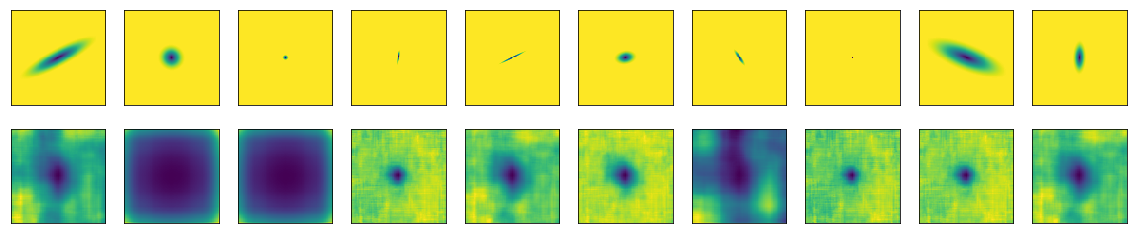

In [21]:
#teste a predição com os parametros de teste
decoded_imgs = decoder_instance.predict( testStructures )

nFigs = 10
plt.figure(figsize=(20, 4))
for i in range(nFigs):
    # display original
    ax = plt.subplot(2, nFigs, i+1)
    plt.imshow(testStructures[i].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, nFigs, i + nFigs + 1)
    plt.imshow(decoded_imgs[i].reshape(getGridParameters().NI, getGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()